# Capstone 2 Modeling (day)

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
  * Data Collection 
   * Data Organization
  * Data Definition 
  * Data Cleaning
 
3.   Exploratory Data Analysis
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   Pre-processing and Training Data Development
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
  
5.   **Modeling**
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

## Data Collection

In [1]:
#load python packages
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pmdarima.metrics import smape # Symmetric Mean Absolute Percentage Error.
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
%matplotlib inline

In [2]:
# load the csv files in data/processed folder
df2 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df24.csv', index_col='Date')
df6 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2016.csv', index_col='Date')
df7 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2017.csv', index_col='Date')
# change indexes to time series
df2.index = pd.to_datetime(df2.index)
df6.index = pd.to_datetime(df6.index)
df7.index = pd.to_datetime(df7.index)
# set the index frequency
df2.index.freq="D"
df6.index.freq="D"
df7.index.freq="D"
df2.head()

11:00:00  12:00:00  13:00:00  14:00:00  15:00:00  16:00:00  \
Date                                                                     
2016-01-04     16.39     36.27     78.68     51.44     57.70    148.93   
2016-01-05     22.45     27.75      7.25     30.64    100.67    149.72   
2016-01-06     33.59     41.48    111.56     92.00     94.83     94.27   
2016-01-07      8.40     23.30     54.49     42.28    116.13    101.65   
2016-01-08     27.25     86.00     48.34     65.21    186.20    158.67   

            17:00:00  18:00:00  19:00:00  20:00:00  21:00:00  22:00:00  \
Date                                                                     
2016-01-04     74.55     50.34     56.02     79.35     58.34     31.68   
2016-01-05     43.14     68.53     93.65     75.90     27.45     31.70   
2016-01-06     45.26     70.35     57.22     52.53     46.87     49.12   
2016-01-07     52.04     47.96    128.00     77.01     91.02     75.42   
2016-01-08     93.76    117.30    143.23    105.70    182.96     89.71   

            23:00:00    Daily  
Date                           
2016-01-04      0.00   739.69  
2016-01-05      0.00   678.85  
2016-01-06      0.00   789.08  
2016-01-07      0.00   817.70  
2016-01-08     64.12  1368.45

In [3]:
# load the csv files in data/processed folder
dfts = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\dfts.csv', index_col='Date')
dfts.index = pd.to_datetime(dfts.index)
display(dfts.head())

sales
Date                      
2016-01-04 11:00:00  16.39
2016-01-04 12:00:00  36.27
2016-01-04 13:00:00  78.68
2016-01-04 14:00:00  51.44
2016-01-04 15:00:00  57.70

In [4]:
# let's check the monthly sum to determine how many months to test and forecast
monthly_df6 = df6.Daily.groupby(df6.index.month).sum()
monthly_df7 = df7.Daily.groupby(df7.index.month).sum()
display(monthly_df6)
monthly_df7

Date
1     29670.498889
2     37205.323704
3     34261.162406
4     39669.840000
5     40581.600000
6     35244.510000
7     35850.027059
8     36106.890000
9     39045.180000
10    38924.410000
11    35246.587941
12    33431.255584
Name: Daily, dtype: float64

Date
1     31628.213333
2     30722.160000
3     39216.192059
4     40090.300000
5     39922.728889
6     35847.533871
7     38372.780000
8     38483.515021
9     44649.233559
10    42940.750000
11    34170.149197
12    34242.660342
Name: Daily, dtype: float64

We will use 9/1/2017 until end of 2017 as testing date, while forecasting until end of March 2018 to verify the prediction should go up by end of March.

# Correlograms

Autocorrelogram & Partial Autocorrelogram is useful that to estimate each models parameters.

In [5]:
#train_test_split and forecast dates
train_start,train_end = '2016-01-04','2017-08-31'
test_start,test_end = '2017-09-01','2017-12-31'
forecast_start, forecast_end = '2018-01-01','2018-03-31'
train = df2['Daily'][train_start:train_end].dropna()
test = df2['Daily'][test_start:test_end].dropna()

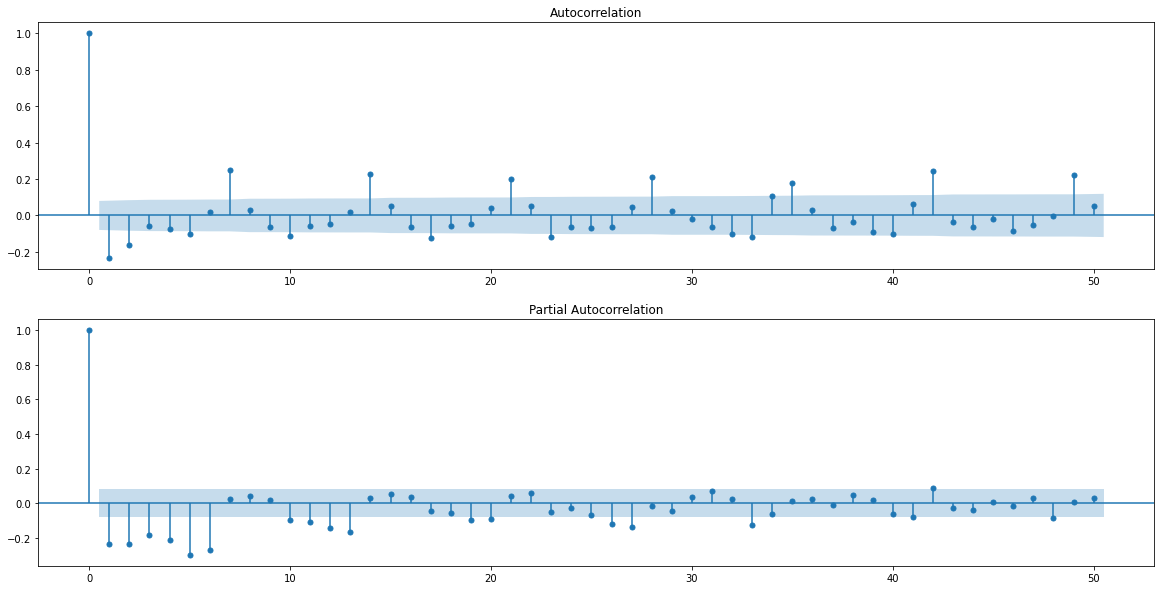

In [6]:
#we use train.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(train.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train.diff().dropna(), lags=50, ax=ax[1])
plt.show()

From Autocorrelation, we can see that there's a recurring pattern every 7 periods, indicating a weekly pattern exists; hence p=7.
Since our time series data is stationary, no differencing is needed, so d=0.
Since there's seasonality, we will use Seasonal Moving Average models instead of regular Moving Average models.

# ARIMA Modeling
We will use SARIMAX but with seasonal_order = (0,0,0,0), so it has same result as ARIMA

# Finding best q for ARIMA hyperparameter

# Grid search for best params
#change from markdown to code to run
#Grid search method for best parameters based on MSE, smape, and AIC
#create empty lists to store values
p_list = []
d_list = []
q_list = []
trend_list = []
MSE_list = []
SMAPE_list = []
AIC_list = []
#iternation
for p in [6, 7]: #6,7 some people say 6, some say 7
    for d in [0, 1]:
        for q in range(8):
            for trnd in [None, 'c', 't', 'ct']:
                # fit the model, trend is constant number which should be daily average sales
                arima = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), freq='D', seasonal_order=(0,0,0,0), trend=trnd, 
                                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
                # get the prediction
                pred = arima.predict(train_end,test_end)[1:]
                # calculate the MSE and smape
                MSE = mean_squared_error(test,pred)
                SMAPE = smape(test,pred)
                # append the values
                p_list.append(p)
                d_list.append(d)
                q_list.append(q)
                trend_list.append(trnd)
                MSE_list.append(MSE)
                SMAPE_list.append(SMAPE)
                AIC_list.append(arima.aic)

#create a dict to store the key:values then change to dataframe for easier/cleaner access
arima_score_dict = {
    'p': p_list,
    'd': d_list,
    'q': q_list,
    'trend': trend_list,
    'MSE': MSE_list,
    'SMAPE': SMAPE_list,
    'AIC': AIC_list,
}

arima_score_df = pd.DataFrame.from_dict(arima_score_dict)
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
arima_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\arima_gridsearch.csv',
                      index=False)

In [7]:
# load the grid search data
arima_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\arima_gridsearch.csv')
display(arima_score_df.loc[arima_score_df['MSE']==arima_score_df.MSE.min()])
display(arima_score_df.loc[arima_score_df['SMAPE']==arima_score_df.SMAPE.min()])
arima_score_df.loc[arima_score_df['AIC']==arima_score_df.AIC.min()]

p  d  q trend          MSE      SMAPE         AIC
0  6  0  0   NaN  62646.29952  15.184628  8182.39045

p  d  q trend           MSE      SMAPE          AIC
8  6  0  2   NaN  67264.432566  14.647869  8150.271316

p  d  q trend           MSE      SMAPE          AIC
124  7  1  7   NaN  81600.114016  17.745096  8023.303576

It looks like no trend and order=(6,0,0) or order=(6,0,2) had best results, order=(7,1,7) may have a bit lower AIC score but the MSE and smape is much more higher.

# Auto_arima to search for best params
#change from markdown to code to run
auto_arima(train, exogenous=None, 
           start_p=6, d=None, start_q=0, max_p=10, max_d=1, max_q=10, # grid search for order params
           start_P=0, D=None, start_Q=0, max_P=0, max_D=0, max_Q=0, m=0, #grid search for seasonal order params, seaonal=True
           max_order=21, seasonal=False, stationary=True, information_criterion='aic', suppress_warnings=True) 
#maxorder = allowed sum of p and q, since an year has 12 months, so we'll have 11 as max for p, 10 for q
#data already stationary so stationary=True

#Result order=(10,0,0)

# ARMA order select to search for best params
#change from markdown to code to run
resDiff = sm.tsa.arma_order_select_ic(train, max_ar=10, max_ma=10, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

#Result p=8, q=8, d has to be 0, since it's designed for ARMA

In [8]:
#need to change working directory to data, where the data are saved
path="C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\figures"
os.chdir(path)

In [9]:
# create empty lists to save the data
model_list = []
R2_list = []
mean_SE_list = []
mean_AE_list = []
smape_list = []
aic_list = []

In [10]:
# create a function to take in the order parameters for ARIMA, fit, plot diagnostics, display metrics scores,
# plot the test vs predict and save everything
def ARIMA101(p, d, q):
    #fit the model with given params
    arima = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), seasonal_order=(0,0,0,0), freq='D',
                                     enforce_stationarity=False, enforce_invertibility=False,).fit()
    #get the diagnostics for the model
    arima.plot_diagnostics(figsize=(15, 12))
    plt.savefig('arima{}_diagnostics.png'.format(str(p)+str(d)+str(q)))
    plt.show()
    #predict using the model
    pred = arima.predict(train_end,test_end)[1:]
    forecast = arima.predict(test_end,forecast_end)[1:]
    #record the metrics and model name
    model_list.append('ARIMA{}'.format(str(p)+str(d)+str(q)))
    R2_list.append(r2_score(test,pred))
    mean_SE_list.append(mean_squared_error(test,pred))
    mean_AE_list.append(mean_absolute_error(test,pred))
    smape_list.append(smape(test,pred))
    aic_list.append(arima.aic)
    print('ARIMA{} model R2:'.format(str(p)+str(d)+str(q)), r2_score(test,pred))
    print('ARIMA{} model MSE:'.format(str(p)+str(d)+str(q)), mean_squared_error(test,pred))
    print('ARIMA{} model MAE:'.format(str(p)+str(d)+str(q)), mean_absolute_error(test,pred))
    print('ARIMA{} model smape:'.format(str(p)+str(d)+str(q)), smape(test,pred))
    print('ARIMA{} model AIC:'.format(str(p)+str(d)+str(q)), arima.aic)
    #view the plot of test vs pred
    pd.DataFrame({'test':test,'pred':pred, 'forecast': forecast}).plot()
    plt.suptitle('ARIMA{} test vs prediction & forecast'.format(str(p)+str(d)+str(q)))
    plt.legend(["Test", "Predict", "Forecast"])
    plt.savefig('arima{}_test_pred.png'.format(str(p)+str(d)+str(q)))
    plt.show()
    return

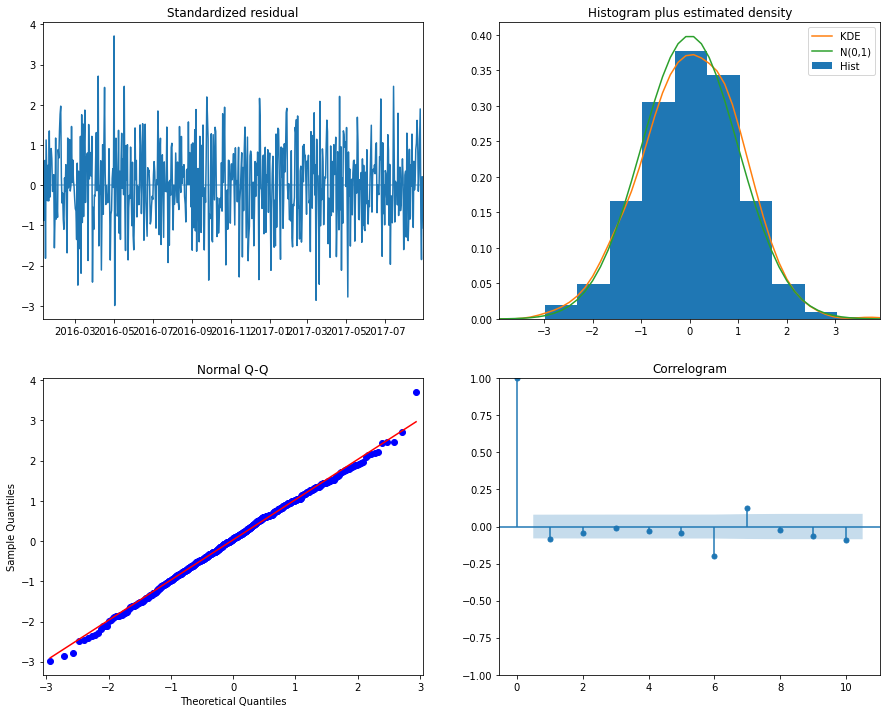

ARIMA600 model R2: 0.19535591366163874
ARIMA600 model MSE: 62646.29952011323
ARIMA600 model MAE: 195.1022665152943
ARIMA600 model smape: 15.184628380285208
ARIMA600 model AIC: 8182.390450165786


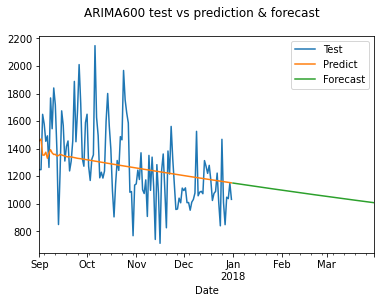

In [11]:
ARIMA101(6,0,0)

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In the top right plot, we see that the KDE line follows pretty close with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). This is also an indication that the residuals are normally distributed.

The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


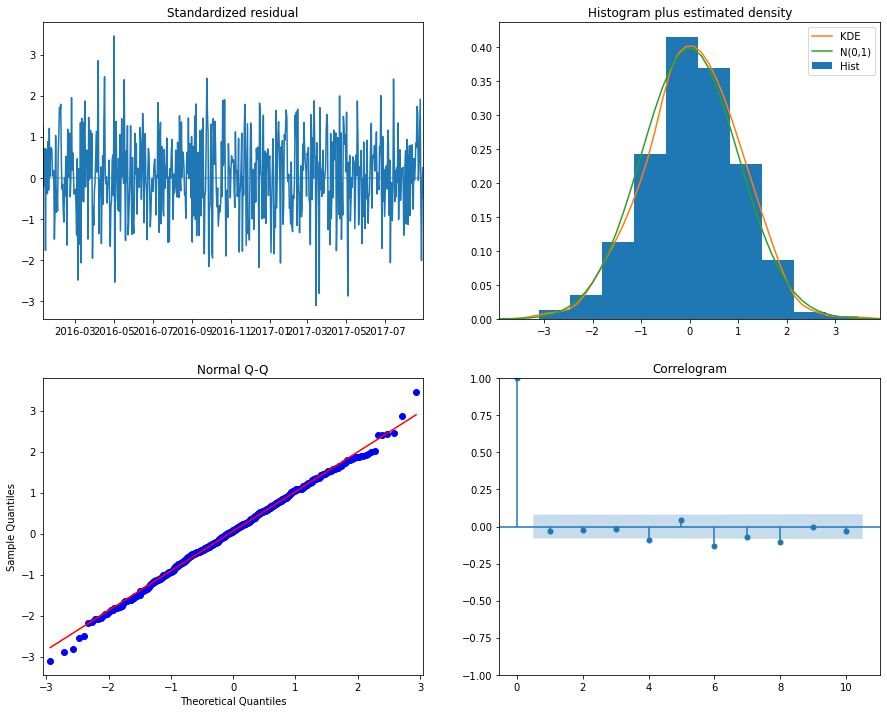

ARIMA602 model R2: 0.1360395059281715
ARIMA602 model MSE: 67264.43256603902
ARIMA602 model MAE: 188.4386832581724
ARIMA602 model smape: 14.647868767359803
ARIMA602 model AIC: 8150.27131562127


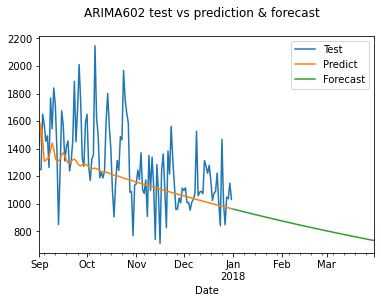

In [12]:
ARIMA101(6,0,2) #lowest AIC from grid search with p=6-7, d=0-1, q=0-8

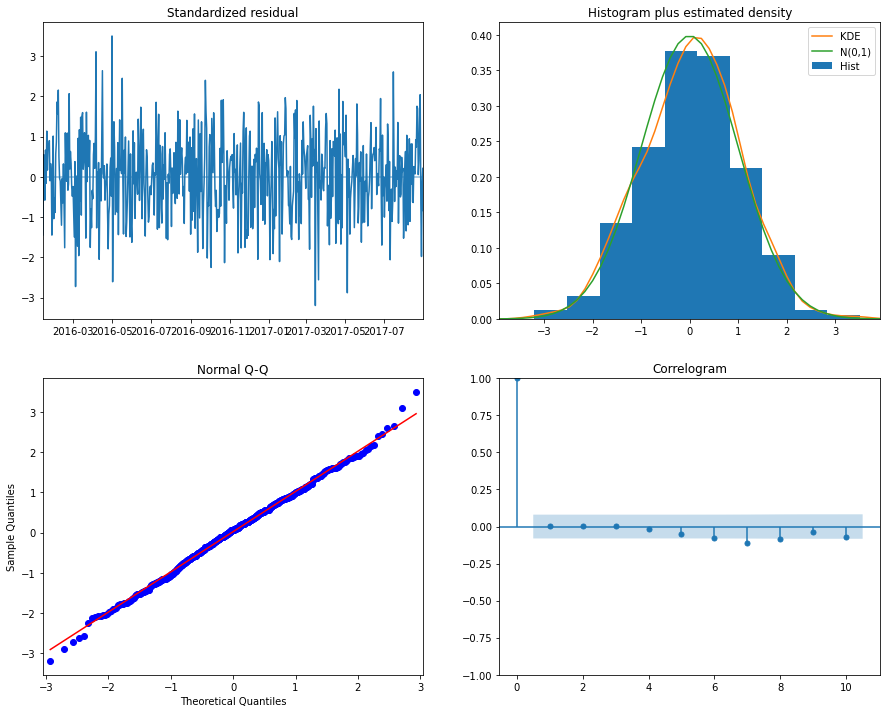

ARIMA1000 model R2: 0.07544575276348087
ARIMA1000 model MSE: 71982.01450599598
ARIMA1000 model MAE: 220.92099674440786
ARIMA1000 model smape: 17.243152919422865
ARIMA1000 model AIC: 8091.192979403077


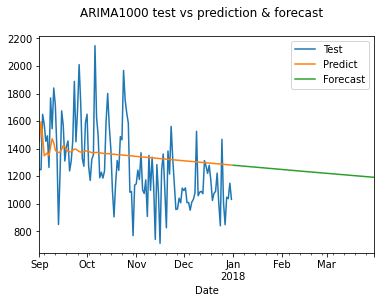

In [13]:
ARIMA101(10,0,0) #best params based on auto_arima

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


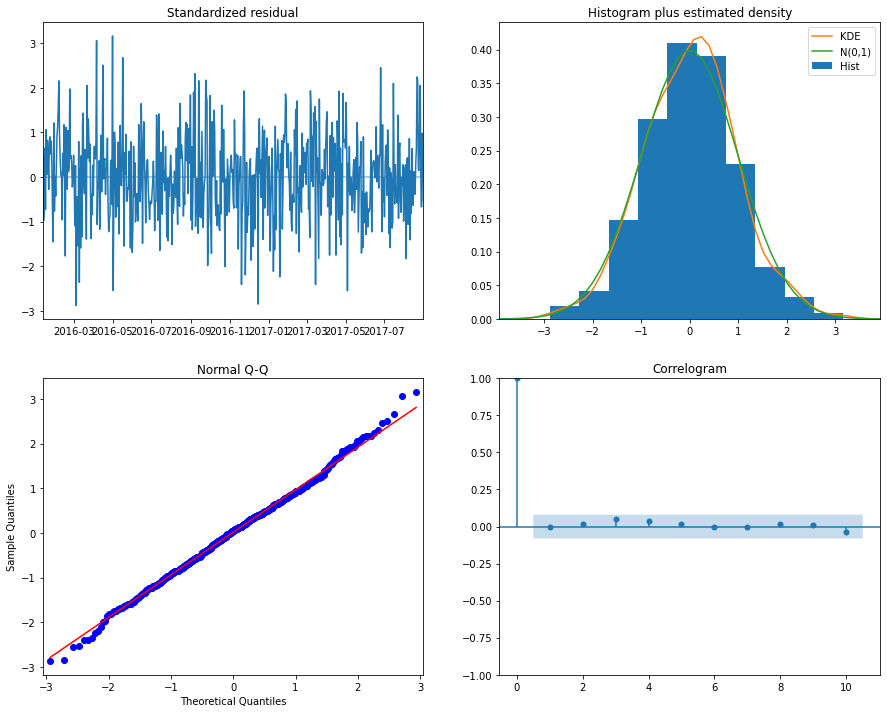

ARIMA808 model R2: -0.10969601657363293
ARIMA808 model MSE: 86396.39588591365
ARIMA808 model MAE: 236.98315376158524
ARIMA808 model smape: 18.320195937104256
ARIMA808 model AIC: 8025.733352252946


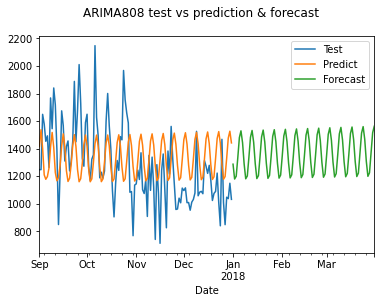

In [14]:
ARIMA101(8,0,8) #best params based on arma order select

# SARIMA
The method is suitable for univariate time series with trend and/or seasonal components.
Let's check and see which parameters from ARIMA gave best result and take the order params from them.

# Grid search for best params
#change from markdown to code to run
#Since we are setting seasonality in weekly basis, m=7, it will influence order params so we need to adjust them as well
#we know d = 0 b/c dataset is stationary, we will leave it as it is.
#for SARIMAX the higher the order the slower it takes, we will evenly distribute to maximum order of 12; maximum p/P/q/Q=3
#D is usually 0 or 1
#create empty lists to store values
p_list = []
d_list = []
q_list = []
P_list = []
D_list = []
Q_list = []
MSE_list = []
SMAPE_list = []
AIC_list = []
#gridsearch iternation
for p in range(4):
    for q in range(4):
        for P in range(4):
            for D in [0,1]:
                for Q in range(4):
                    # fit the model
                    sarima = sm.tsa.statespace.SARIMAX(train, order=(p,0,q), seasonal_order=(P,D,Q,7), freq='D',
                                                      enforce_stationarity=False, enforce_invertibility=False,).fit()
                    # get the prediction
                    pred = sarima.predict(train_end,test_end)[1:]
                    # calculate the MSE and smape
                    MSE = mean_squared_error(test,pred)
                    SMAPE = smape(test,pred)
                    # append the values
                    p_list.append(p)
                    d_list.append(0)
                    q_list.append(q)
                    P_list.append(P)
                    D_list.append(D)
                    Q_list.append(Q)
                    MSE_list.append(MSE)
                    SMAPE_list.append(SMAPE)
                    AIC_list.append(sarima.aic) 
#create a dict to store the key:values then change to dataframe for easier/cleaner access
sarima_score_dict = {
    'p': p_list,
    'd': d_list,
    'q': q_list,
    'P': P_list,
    'D': D_list,
    'Q': Q_list,
    'MSE': MSE_list,
    'SMAPE': SMAPE_list,
    'AIC': AIC_list,
}

sarima_score_df = pd.DataFrame.from_dict(sarima_score_dict)
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
sarima_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\sarima_gridsearch.csv',
                       index=False)

In [15]:
# load the grid search data most params 0-3, D=0,1 d=0
sarima_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\sarima_gridsearch.csv')
display(sarima_score_df.loc[sarima_score_df['MSE']==sarima_score_df.MSE.min()])
display(sarima_score_df.loc[sarima_score_df['SMAPE']==sarima_score_df.SMAPE.min()])
sarima_score_df.loc[sarima_score_df['AIC']==sarima_score_df.AIC.min()]

p  d  q  P  D  Q           MSE      SMAPE          AIC
112  0  0  3  2  0  0  59874.536769  14.511142  8110.910367

p  d  q  P  D  Q           MSE      SMAPE          AIC
162  1  0  1  0  0  2  61137.532898  13.808875  8071.853298

p  d  q  P  D  Q           MSE      SMAPE          AIC
231  1  0  3  0  1  3  81758.211881  17.355354  7680.817211

In [16]:
# create a function to take in the order parameters for SARIMA, fit, plot diagnostics, display metrics scores,
# plot the test vs predict and save everything
def SARIMA101(p, d, q, P, D, Q):
    #fit the model with given params
    sarima = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,7), freq='D',
                                     enforce_stationarity=False, enforce_invertibility=False,).fit()
    #get the diagnostics for the model
    sarima.plot_diagnostics(figsize=(15, 12))
    plt.savefig('sarima{}_diagnostics.png'.format(str(p)+str(d)+str(q)+str(P)+str(D)+str(Q)))
    plt.show()
    #predict using the model
    pred = sarima.predict(train_end,test_end)[1:]
    forecast = sarima.predict(test_end,forecast_end)[1:]
    #record the metrics and model name
    model_list.append('SARIMA{}'.format(str(p)+str(d)+str(q)+str(P)+str(D)+str(Q)))
    R2_list.append(r2_score(test,pred))
    mean_SE_list.append(mean_squared_error(test,pred))
    mean_AE_list.append(mean_absolute_error(test,pred))
    smape_list.append(smape(test,pred))
    aic_list.append(sarima.aic)
    print('SARIMA{} model R2:'.format(str(p)+str(d)+str(q)+str(P)+str(D)+str(Q)), r2_score(test,pred))
    print('SARIMA{} model MSE:'.format(str(p)+str(d)+str(q)+str(P)+str(D)+str(Q)), mean_squared_error(test,pred))
    print('SARIMA{} model MAE:'.format(str(p)+str(d)+str(q)+str(P)+str(D)+str(Q)), mean_absolute_error(test,pred))
    print('SARIMA{} model smape:'.format(str(p)+str(d)+str(q)+str(P)+str(D)+str(Q)), smape(test,pred))
    print('SARIMA{} model AIC:'.format(str(p)+str(d)+str(q)+str(P)+str(D)+str(Q)), sarima.aic)
    #view the plot of test vs pred
    pd.DataFrame({'test':test,'pred':pred, 'forecast':forecast}).plot()
    plt.suptitle('SARIMA{} test vs prediction & forecast'.format(str(p)+str(d)+str(q)+str(P)+str(D)+str(Q)))
    plt.legend(["Test", "Predict", "Forecast"])
    plt.savefig('sarima{}_test_pred.png'.format(str(p)+str(d)+str(q)+str(P)+str(D)+str(Q)))
    plt.show()
    return

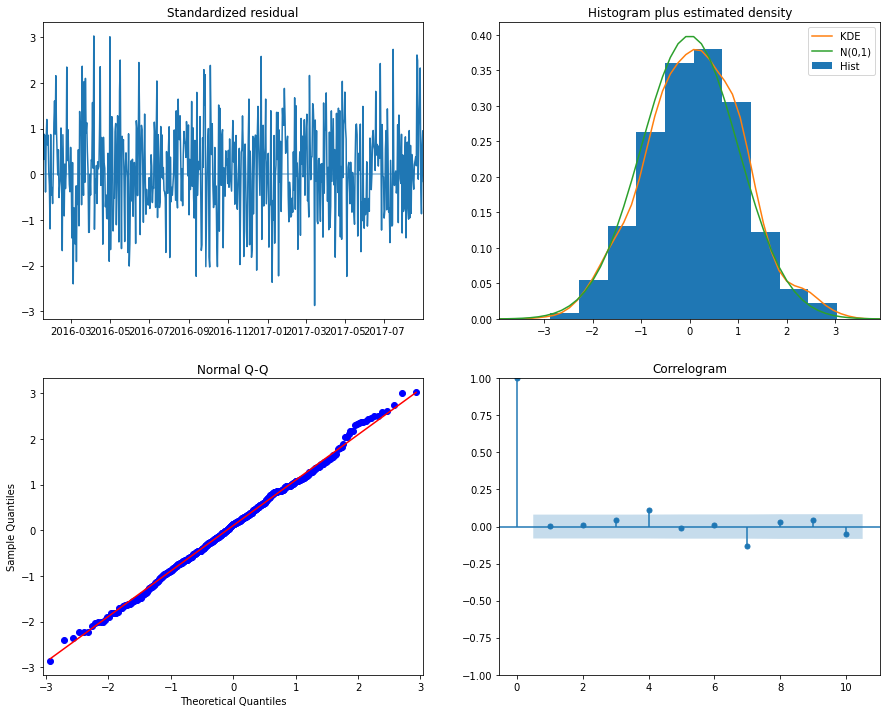

SARIMA003200 model R2: 0.23095709877867765
SARIMA003200 model MSE: 59874.5367693768
SARIMA003200 model MAE: 185.9108452028837
SARIMA003200 model smape: 14.511141688274165
SARIMA003200 model AIC: 8110.910367399026


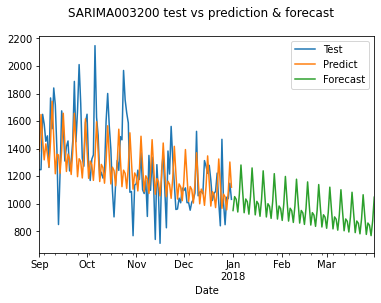

In [17]:
SARIMA101(0,0,3,2,0,0)

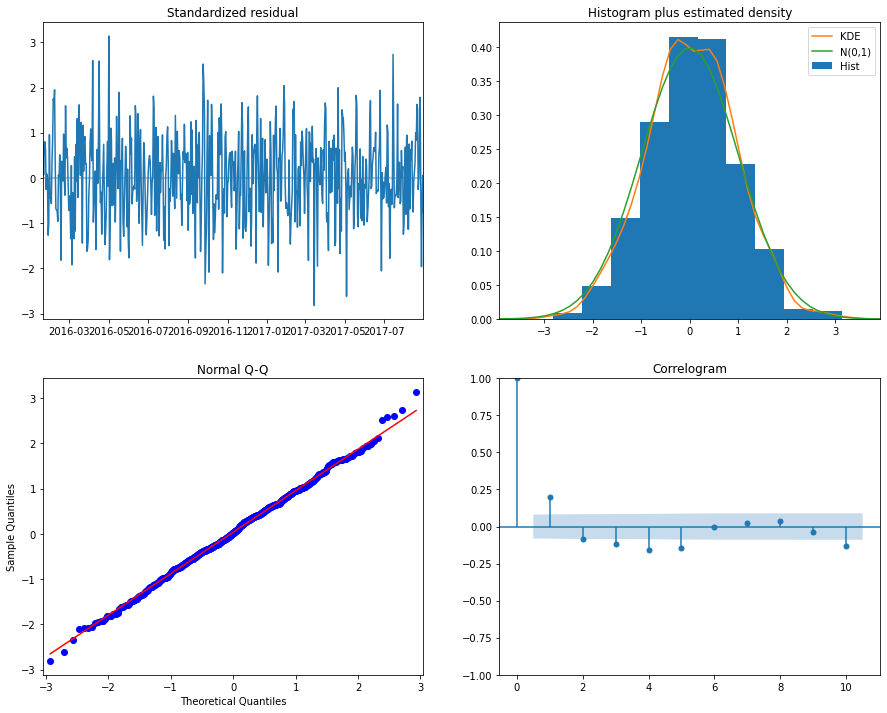

SARIMA101002 model R2: 0.2147348737819631
SARIMA101002 model MSE: 61137.532898076985
SARIMA101002 model MAE: 178.74982350392835
SARIMA101002 model smape: 13.808875321855387
SARIMA101002 model AIC: 8071.853298268574


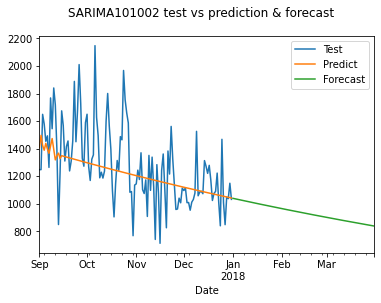

In [18]:
SARIMA101(1,0,1,0,0,2)

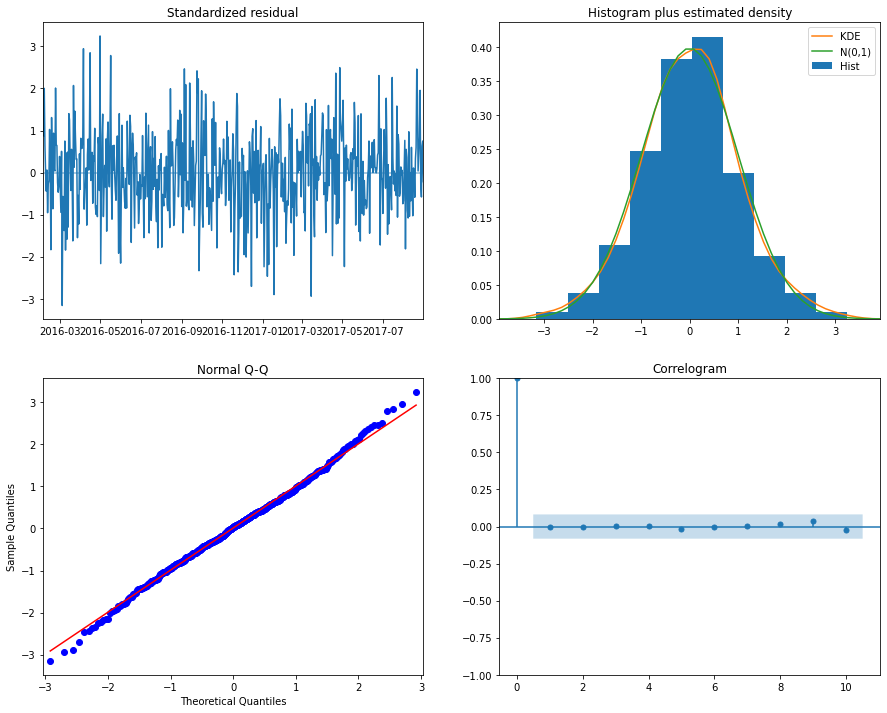

SARIMA103013 model R2: -0.050122069518073964
SARIMA103013 model MSE: 81758.21188108082
SARIMA103013 model MAE: 222.37138189268646
SARIMA103013 model smape: 17.35535402385477
SARIMA103013 model AIC: 7680.817211322488


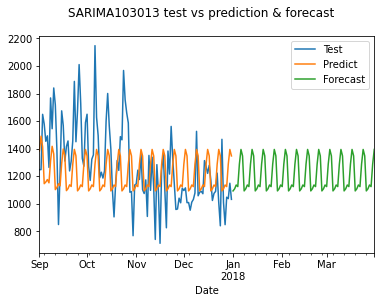

In [19]:
SARIMA101(1,0,3,0,1,3)

# Holtwinters ExponentialSmoothing
This method is suitable for univariate time series with trend and/or seasonal components.

In [20]:
# Grid search for best params
#change from markdown to code to run
#Grid search method for best parameters based on MSE, smape, and AIC
#create empty lists to store values
trend_list = []
seasonal_list = []
MSE_list = []
SMAPE_list = []
AIC_list = []
#iternation
for trnd in [None, 'add', 'mul']:
    for season in [None, 'add', 'mul']:
        # fit the model, trend is constant number which should be daily average sales
        HES = ExponentialSmoothing(train, freq='D', seasonal_periods=7 ,trend=trnd, seasonal=season).fit()
        # get the prediction
        pred = HES.predict(train_end,test_end)[1:]
        # calculate the MSE and smape
        MSE = mean_squared_error(test,pred)
        SMAPE = smape(test,pred)
        # append the values
        trend_list.append(trnd)
        seasonal_list.append(season)
        MSE_list.append(MSE)
        SMAPE_list.append(SMAPE)
        AIC_list.append(HES.aic)

#create a dict to store the key:values then change to dataframe for easier/cleaner access
HES_score_dict = {
    'trend': trend_list,
    'seasonal': seasonal_list,
    'MSE': MSE_list,
    'SMAPE': SMAPE_list,
    'AIC': AIC_list,
}

HES_score_df = pd.DataFrame.from_dict(HES_score_dict)
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
HES_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\HES_gridsearch.csv',
                      index=False)

In [21]:
# load the grid search data
HES_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\HES_gridsearch.csv')
display(HES_score_df.loc[HES_score_df['MSE']==HES_score_df.MSE.min()])
display(HES_score_df.loc[HES_score_df['SMAPE']==HES_score_df.SMAPE.min()])
HES_score_df.loc[HES_score_df['AIC']==HES_score_df.AIC.min()]

trend seasonal           MSE     SMAPE          AIC
8   mul      mul  86502.789302  18.58239  6406.942792

trend seasonal           MSE     SMAPE          AIC
8   mul      mul  86502.789302  18.58239  6406.942792

trend seasonal          MSE      SMAPE          AIC
1   NaN      add  100748.4621  20.234862  6396.864806

HES model R2: -0.11106255910948049
HES model MSE: 86502.78930191109
HES model MAE: 241.07512773083783
HES model smape: 18.582389992479744
HES model AIC: 6406.942791508538


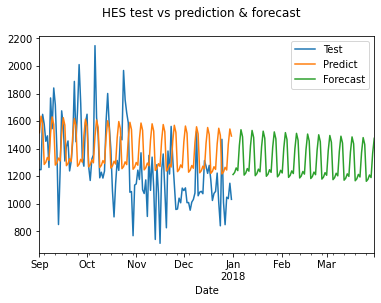

In [22]:
#since the AIC is only slihgt better, we will take the 8th params, where trend and seasonal are both multiplicative
HES = ExponentialSmoothing(train, freq='D', seasonal_periods=7 ,trend='mul', seasonal='mul',).fit()
#predict using the model
pred = HES.predict(train_end,test_end)[1:]
forecast = HES.predict(test_end,forecast_end)[1:]
#record the metrics and model name
model_list.append('HES')
R2_list.append(r2_score(test,pred))
mean_SE_list.append(mean_squared_error(test,pred))
mean_AE_list.append(mean_absolute_error(test,pred))
smape_list.append(smape(test,pred))
aic_list.append(HES.aic)
print('HES model R2:', r2_score(test,pred))
print('HES model MSE:', mean_squared_error(test,pred))
print('HES model MAE:', mean_absolute_error(test,pred))
print('HES model smape:', smape(test,pred))
print('HES model AIC:', HES.aic)
#view the plot of test vs pred
pd.DataFrame({'test':test,'pred':pred, 'forecast':forecast}).plot()
plt.suptitle('HES test vs prediction & forecast')
plt.legend(["Test", "Predict","Forecast"])
plt.savefig('HES_test_pred.png')
plt.show()

# ARIMAX
ARIMA with features, we will add time related features: day of week and month and see if it performs better than SARIMA

In [23]:
# creating a new dataframe with additional date so we can do forecast
# since it's univariate, we will take the df2 daily sales, then just append 1s for the rest of the sales
Date = pd.date_range('2016-01-04', periods=940, freq='D')
daily_list = list(df2.Daily)
for i in range(len(Date)-len(daily_list)):
    daily_list.append(1)
buf = {'Daily':daily_list}
buf = pd.DataFrame.from_dict(buf)
buf = buf.set_index(Date)

#month one hot encoding
buf['month'] = buf.index.month
month_dummies = pd.get_dummies(buf['month'])
month_dummies.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
buf = pd.concat([buf, month_dummies], axis=1).drop(['month'],axis=1)
#dayofweek one hot encoding
buf['dayofweek'] = buf.index.weekday
week_dummies = pd.get_dummies(buf['dayofweek'])
week_dummies.columns = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
buf = pd.concat([buf, week_dummies], axis=1).drop(['dayofweek'],axis=1)
#defining exog_train and test and forecast
exog_train = buf[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                  'Mon','Tue','Wed','Thu','Fri','Sat','Sun']]['2016-01-04':'2017-08-31'].dropna()
exog_test = buf[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                 'Mon','Tue','Wed','Thu','Fri','Sat','Sun']]['2017-09-01':'2017-12-31'].dropna()
#exog forecast starting date has to be the same as exog_test's starting date
exog_forecast = buf[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                 'Mon','Tue','Wed','Thu','Fri','Sat','Sun']]['2017-09-01':'2018-03-31'].dropna()

# Grid search for best params
#change from markdown to code to run
#Grid search method for best parameters based on MSE, smape, and AIC
#create empty lists to store values
p_list = []
d_list = []
q_list = []
MSE_list = []
SMAPE_list = []
AIC_list = []
#iternation
for p in range(11):
    for d in [0, 1]:
        for q in range(11):
            # fit the model, trend is constant number which should be daily average sales
            arimax = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), seasonal_order=(0,0,0,0), freq='D', exog=exog_train,
                                               enforce_stationarity=False, enforce_invertibility=False,).fit()
            # get the prediction
            pred = arimax.predict(train_end,test_end,exog = exog_test)[1:]
            # calculate the MSE and smape
            MSE = mean_squared_error(test,pred)
            SMAPE = smape(test,pred)
            # append the values
            p_list.append(p)
            d_list.append(d)
            q_list.append(q)
            MSE_list.append(MSE)
            SMAPE_list.append(SMAPE)
            AIC_list.append(arimax.aic)

#create a dict to store the key:values then change to dataframe for easier/cleaner access
arimax_score_dict = {
    'p': p_list,
    'd': d_list,
    'q': q_list,
    'MSE': MSE_list,
    'SMAPE': SMAPE_list,
    'AIC': AIC_list,
}

arimax_score_df = pd.DataFrame.from_dict(arimax_score_dict)
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
arimax_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\arimax_gridsearch.csv',
                      index=False)

In [24]:
# load the grid search data
arimax_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\arimax_gridsearch.csv')
display(arimax_score_df.loc[arimax_score_df['MSE']==arimax_score_df.MSE.min()])
display(arimax_score_df.loc[arimax_score_df['SMAPE']==arimax_score_df.SMAPE.min()])
arimax_score_df.loc[arimax_score_df['AIC']==arimax_score_df.AIC.min()]

p  d  q          MSE      SMAPE          AIC
202  9  0  4  65362.72941  15.099207  7985.319401

p  d  q          MSE      SMAPE         AIC
0  0  0  0  66016.76639  15.073791  8166.19988

p  d   q           MSE     SMAPE          AIC
32  1  0  10  70867.966285  15.76697  7949.068067

In [25]:
# create a function like ARIMA101 but for ARIMAX
def ARIMAX101(p, d, q):
    #fit the model with given params
    arimax = sm.tsa.statespace.SARIMAX(train,order=(p,d,q),seasonal_order=(0,0,0,0),exog=exog_train,freq='D',
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
    #get the diagnostics for the model
    arimax.plot_diagnostics(figsize=(15, 12))
    plt.savefig('arimax{}_diagnostics.png'.format(str(p)+str(d)+str(q)))
    plt.show()
    #predict using the model
    pred = arimax.predict('2017-08-31','2017-12-31',exog = exog_test)[1:]
    forecast = arimax.predict('2017-12-31','2018-03-31',exog = exog_forecast)[1:]
    #record the metrics and model name
    model_list.append('ARIMAX{}'.format(str(p)+str(d)+str(q)))
    R2_list.append(r2_score(test,pred))
    mean_SE_list.append(mean_squared_error(test,pred))
    mean_AE_list.append(mean_absolute_error(test,pred))
    smape_list.append(smape(test,pred))
    aic_list.append(arimax.aic)
    print('ARIMAX{} model R2:'.format(str(p)+str(d)+str(q)), r2_score(test,pred))
    print('ARIMAX{} model MSE:'.format(str(p)+str(d)+str(q)), mean_squared_error(test,pred))
    print('ARIMAX{} model MAE:'.format(str(p)+str(d)+str(q)), mean_absolute_error(test,pred))
    print('ARIMAX{} model smape:'.format(str(p)+str(d)+str(q)), smape(test,pred))
    print('ARIMAX{} model AIC:'.format(str(p)+str(d)+str(q)), arimax.aic)
    #view the plot of test vs pred
    pd.DataFrame({'test':test,'pred':pred,'forecast':forecast}).plot()
    plt.suptitle('ARIMAX{} test vs prediction & forecast'.format(str(p)+str(d)+str(q)))
    plt.legend(["Test", "Predict", "Forecast"])
    plt.savefig('arimax{}_test_pred.png'.format(str(p)+str(d)+str(q)))
    plt.show()
    return

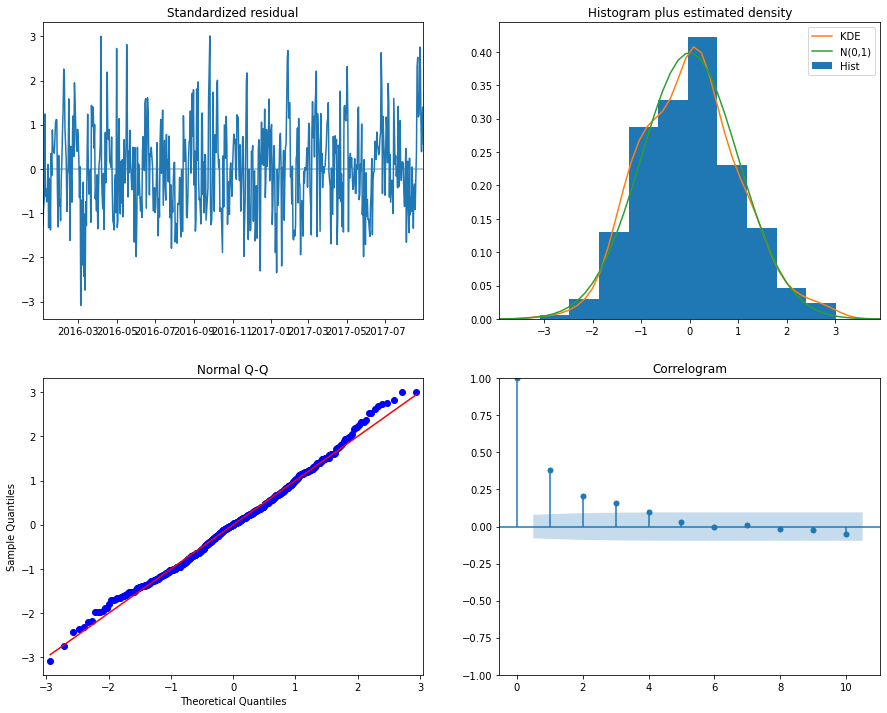

ARIMAX000 model R2: 0.15206482933410903
ARIMAX000 model MSE: 66016.76639034692
ARIMAX000 model MAE: 192.52142226708875
ARIMAX000 model smape: 15.073790616662722
ARIMAX000 model AIC: 8166.199879641494


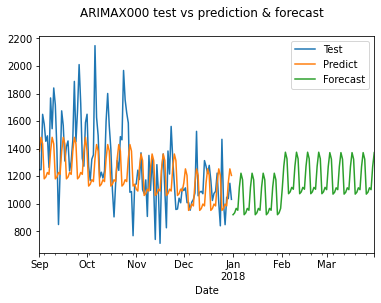

In [26]:
ARIMAX101(0,0,0)

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


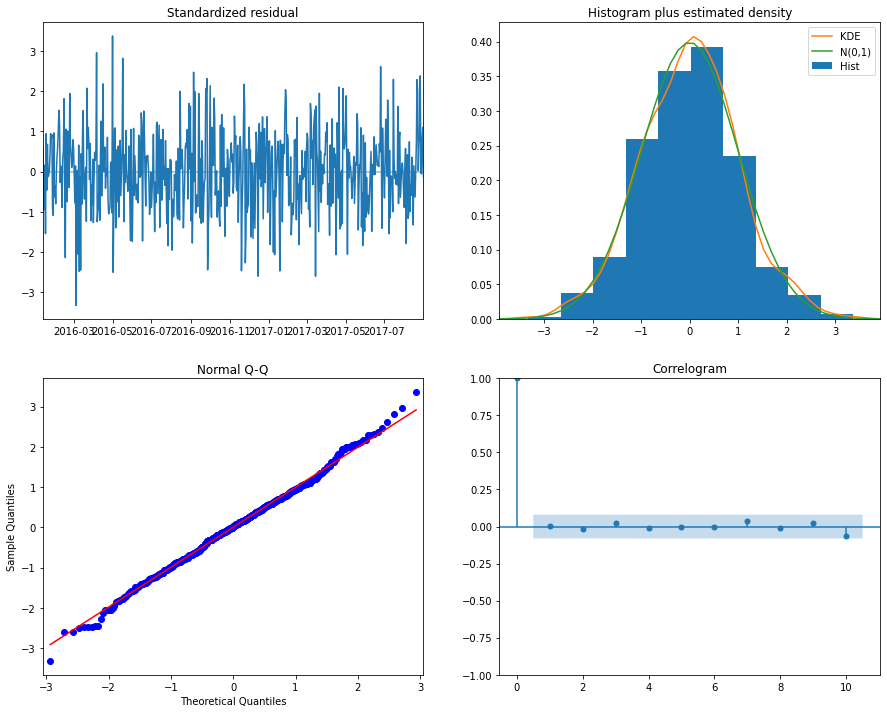

ARIMAX904 model R2: 0.1604654370772226
ARIMAX904 model MSE: 65362.729409573316
ARIMAX904 model MAE: 192.65589780088615
ARIMAX904 model smape: 15.099206641894401
ARIMAX904 model AIC: 7985.319400741722


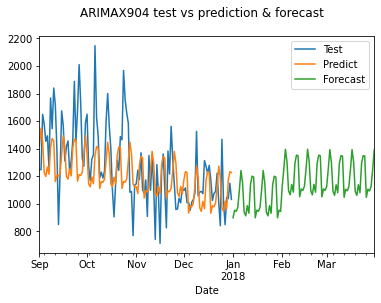

In [27]:
ARIMAX101(9,0,4)

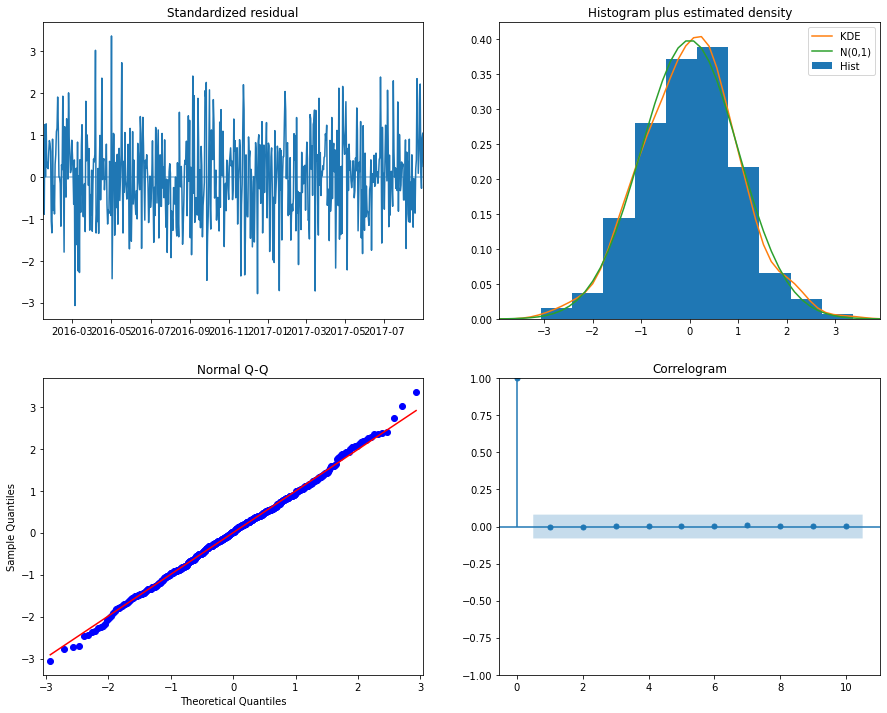

ARIMAX1010 model R2: 0.08975485513051595
ARIMAX1010 model MSE: 70867.96628521245
ARIMAX1010 model MAE: 201.28209395578168
ARIMAX1010 model smape: 15.766969667282938
ARIMAX1010 model AIC: 7949.0680667949955


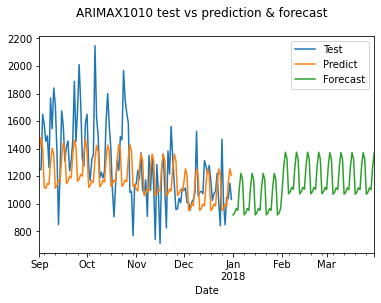

In [28]:
ARIMAX101(1,0,10)

# SARIMAX

# Grid search for best params
#change from markdown to code to run
#Since we are setting seasonality in weekly basis, m=7, it will influence order params so we need to adjust them as well
#we know d = 0 b/c dataset is stationary, we will leave it as it is.
#for SARIMAX the higher the order the slower it takes, we will evenly distribute to maximum order of 12; maximum p/P/q/Q=3
#D is usually 0 or 1
#create empty lists to store values
p_list = []
d_list = []
q_list = []
P_list = []
D_list = []
Q_list = []
MSE_list = []
SMAPE_list = []
AIC_list = []
#gridsearch iternation
for p in range(3):
    for q in range(3):
        for P in range(3):
            for D in [0,1]:
                for Q in range(3):
                    # fit the model
                    sarimax = sm.tsa.statespace.SARIMAX(train, order=(p,0,q), seasonal_order=(P,D,Q,7), freq='D',
                                                       exog=exog_train,
                                                       enforce_stationarity=False, 
                                                       enforce_invertibility=False,).fit()
                    # get the prediction
                    pred = sarimax.predict(train_end,test_end,exog = exog_test)[1:]
                    # calculate the MSE and smape
                    MSE = mean_squared_error(test,pred)
                    SMAPE = smape(test,pred)
                    # append the values
                    p_list.append(p)
                    d_list.append(0)
                    q_list.append(q)
                    P_list.append(P)
                    D_list.append(D)
                    Q_list.append(Q)
                    MSE_list.append(MSE)
                    SMAPE_list.append(SMAPE)
                    AIC_list.append(sarimax.aic)
#create a dict to store the key:values then change to dataframe for easier/cleaner access
sarimax_score_dict = {
    'p': p_list,
    'd': d_list,
    'q': q_list,
    'P': P_list,
    'D': D_list,
    'Q': Q_list,
    'MSE': MSE_list,
    'SMAPE': SMAPE_list,
    'AIC': AIC_list,
}
sarimax_score_df = pd.DataFrame.from_dict(sarimax_score_dict)
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
sarimax_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\sarimax_gridsearch.csv',
                       index=False)

In [29]:
# load the grid search data
sarimax_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\sarimax_gridsearch.csv')
display(sarimax_score_df.loc[sarimax_score_df['MSE']==sarimax_score_df.MSE.min()])
display(sarimax_score_df.loc[sarimax_score_df['SMAPE']==sarimax_score_df.SMAPE.min()])
sarimax_score_df.loc[sarimax_score_df['AIC']==sarimax_score_df.AIC.min()]

p  d  q  P  D  Q           MSE      SMAPE          AIC
7  0  0  0  1  0  1  65903.360646  15.025533  8076.731427

p  d  q  P  D  Q           MSE      SMAPE          AIC
7  0  0  0  1  0  1  65903.360646  15.025533  8076.731427

p  d  q  P  D  Q           MSE      SMAPE          AIC
95  1  0  2  0  1  2  79661.422009  16.738782  7813.190722

In [30]:
# create a function like ARIMA101 but for SARIMAX
def SARIMAX101(p, q, P, D, Q):
    #fit the model with given params
    sarimax = sm.tsa.statespace.SARIMAX(train,order=(p,0,q),seasonal_order=(P,D,Q,7),exog=exog_train,freq='D',
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
    #get the diagnostics for the model
    sarimax.plot_diagnostics(figsize=(15, 12))
    plt.savefig('sarimax{}_diagnostics.png'.format(str(p)+str(q)))
    plt.show()
    #predict using the model
    pred = sarimax.predict('2017-08-31','2017-12-31',exog = exog_test)[1:]
    forecast = sarimax.predict('2017-12-31','2018-03-31',exog = exog_forecast)[1:]
    #record the metrics and model name
    model_list.append('SARIMAX{}'.format(str(p)+str(q)))
    R2_list.append(r2_score(test,pred))
    mean_SE_list.append(mean_squared_error(test,pred))
    mean_AE_list.append(mean_absolute_error(test,pred))
    smape_list.append(smape(test,pred))
    aic_list.append(sarimax.aic)
    print('SARIMAX{} model R2:'.format(str(p)+str(q)), r2_score(test,pred))
    print('SARIMAX{} model MSE:'.format(str(p)+str(q)), mean_squared_error(test,pred))
    print('SARIMAX{} model MAE:'.format(str(p)+str(q)), mean_absolute_error(test,pred))
    print('SARIMAX{} model smape:'.format(str(p)+str(q)), smape(test,pred))
    print('SARIMAX{} model AIC:'.format(str(p)+str(q)), sarimax.aic)
    #view the plot of test vs pred
    pd.DataFrame({'test':test,'pred':pred,'forecast':forecast}).plot()
    plt.suptitle('SARIMAX{} test vs prediction & forecast'.format(str(p)+str(q)))
    plt.legend(["Test", "Predict", "Forecast"])
    plt.savefig('sarimax{}_test_pred.png'.format(str(p)+str(q)))
    plt.show()
    return

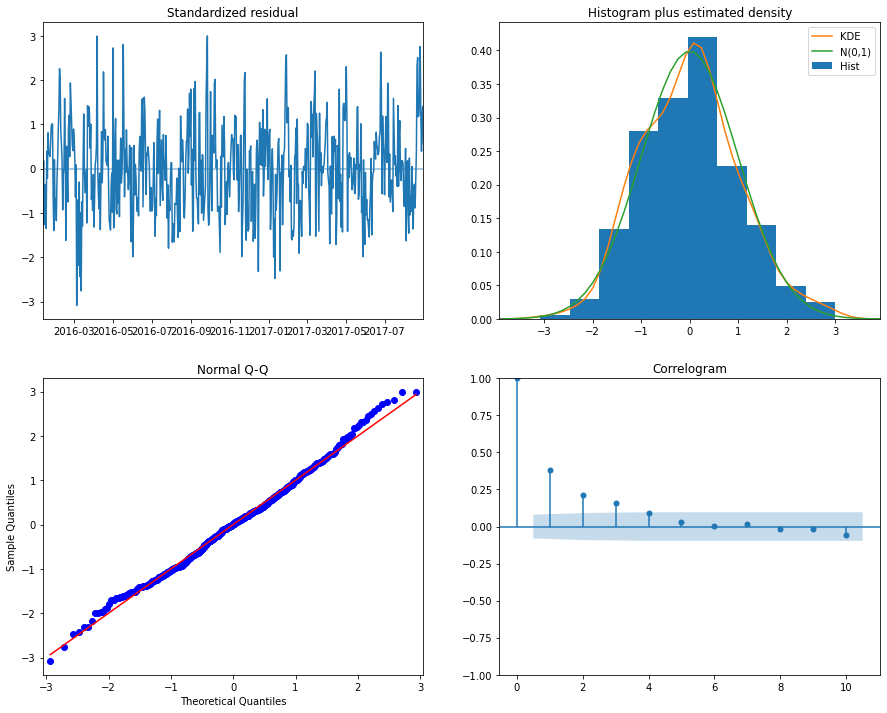

SARIMAX00 model R2: 0.15352143989430145
SARIMAX00 model MSE: 65903.36064613369
SARIMAX00 model MAE: 191.998002965934
SARIMAX00 model smape: 15.025532509418955
SARIMAX00 model AIC: 8076.731427022527


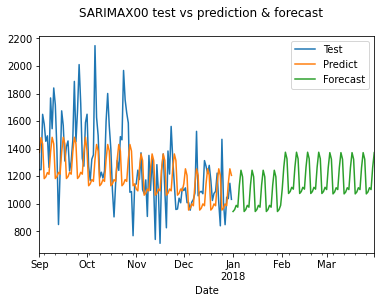

In [31]:
SARIMAX101(0,0,1,0,1)

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


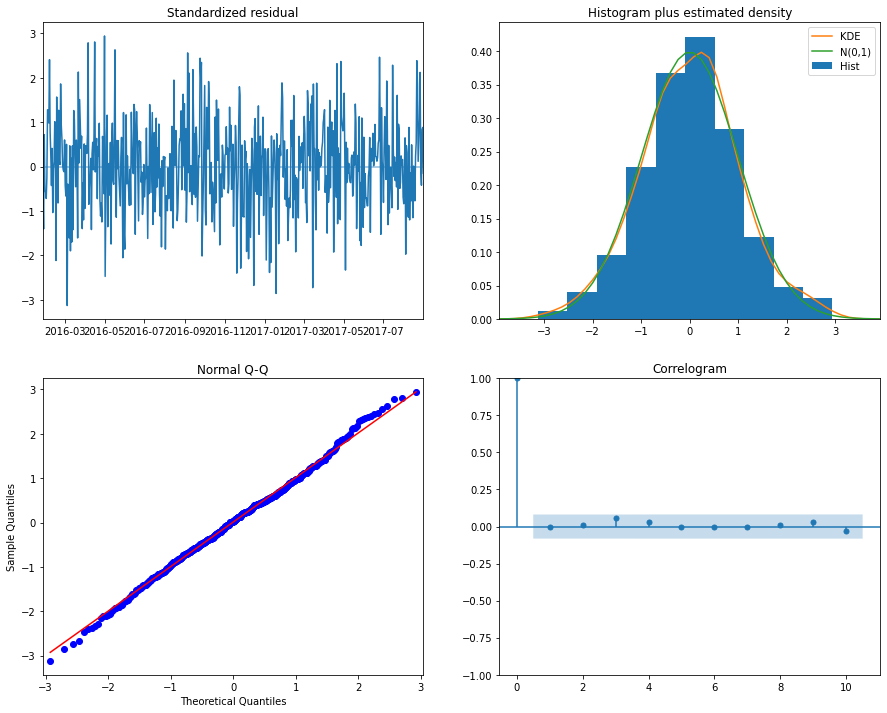

SARIMAX12 model R2: -0.02319039783658794
SARIMAX12 model MSE: 79661.42200915942
SARIMAX12 model MAE: 214.53975401980716
SARIMAX12 model smape: 16.738782026087485
SARIMAX12 model AIC: 7813.190722431233


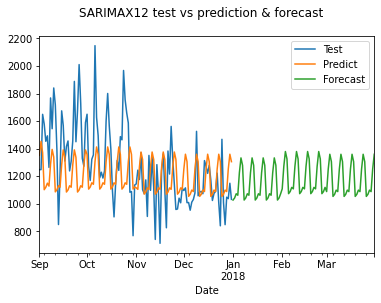

In [32]:
SARIMAX101(1,2,0,1,2)

In [33]:
# create a dict that had all the model score info
model_score_dict = {
    'model': model_list,
    'R2': R2_list,
    'MSE': mean_SE_list,
    'MAE': mean_AE_list,
    'smape': smape_list,
    'AIC': aic_list,
}
# change it to dataframe for easier math usage
model_score_df = pd.DataFrame.from_dict(model_score_dict)
# save the dataframe
model_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\model_scores.csv',
                     index=False)

In [34]:
# read the model scores
model_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\model_scores.csv')
model_score_df

model        R2           MSE         MAE      smape          AIC
0       ARIMA600  0.195356  62646.299520  195.102267  15.184628  8182.390450
1       ARIMA602  0.136040  67264.432566  188.438683  14.647869  8150.271316
2      ARIMA1000  0.075446  71982.014506  220.920997  17.243153  8091.192979
3       ARIMA808 -0.109696  86396.395886  236.983154  18.320196  8025.733352
4   SARIMA003200  0.230957  59874.536769  185.910845  14.511142  8110.910367
5   SARIMA101002  0.214735  61137.532898  178.749824  13.808875  8071.853298
6   SARIMA103013 -0.050122  81758.211881  222.371382  17.355354  7680.817211
7            HES -0.111063  86502.789302  241.075128  18.582390  6406.942792
8      ARIMAX000  0.152065  66016.766390  192.521422  15.073791  8166.199880
9      ARIMAX904  0.160465  65362.729410  192.655898  15.099207  7985.319401
10    ARIMAX1010  0.089755  70867.966285  201.282094  15.766970  7949.068067
11     SARIMAX00  0.153521  65903.360646  191.998003  15.025533  8076.731427
12     SARIMAX12 -0.023190  79661.422009  214.539754  16.738782  7813.190722

In [35]:
# let's view each metric's winner
display(model_score_df.loc[model_score_df['R2']==model_score_df.R2.max()])
display(model_score_df.loc[model_score_df['MSE']==model_score_df.MSE.min()])
display(model_score_df.loc[model_score_df['MAE']==model_score_df.MAE.min()])
display(model_score_df.loc[model_score_df['smape']==model_score_df.smape.min()])
display(model_score_df.loc[model_score_df['AIC']==model_score_df.AIC.min()])

model        R2           MSE         MAE      smape          AIC
4  SARIMA003200  0.230957  59874.536769  185.910845  14.511142  8110.910367

model        R2           MSE         MAE      smape          AIC
4  SARIMA003200  0.230957  59874.536769  185.910845  14.511142  8110.910367

model        R2           MSE         MAE      smape          AIC
5  SARIMA101002  0.214735  61137.532898  178.749824  13.808875  8071.853298

model        R2           MSE         MAE      smape          AIC
5  SARIMA101002  0.214735  61137.532898  178.749824  13.808875  8071.853298

model        R2           MSE         MAE     smape          AIC
7   HES -0.111063  86502.789302  241.075128  18.58239  6406.942792

It appears that SARIMA has the best overall scores, even though HES had lowest AIC its other scores are horrible.
Let's take a look at the their test vs predict & forecast.

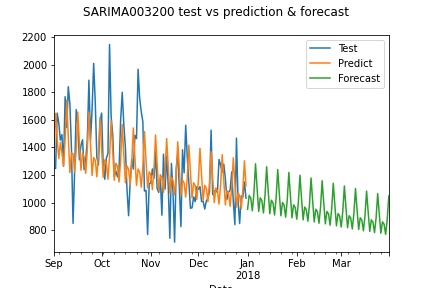

In [36]:
from IPython.display import Image
Image(filename='sarima003200_test_pred.png') 

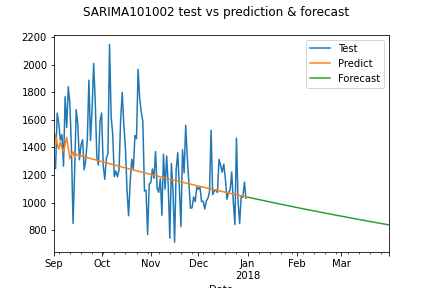

In [37]:
Image(filename='sarima101002_test_pred.png') 

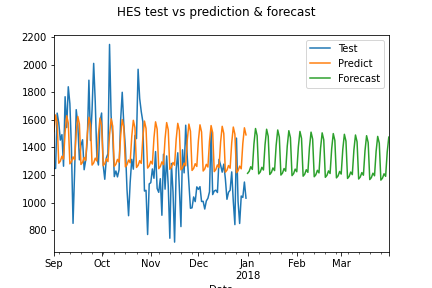

In [38]:
Image(filename='HES_test_pred.png') 

Absolutely unacceptable, from the monthly sums, we could tell that March should be more than January. So the above models with its given parameters are not acceptable.
The only model that had such pattern was ARIMAX&SARIMAX, let's take a look at its score and test vs prediction & orecast.

In [48]:
# let's make a dataframe with only these two models
arimax_models = model_score_df.loc[model_score_df['model'].str.startswith('ARIMAX')]
sarimax_models = model_score_df.loc[model_score_df['model'].str.startswith('SARIMAX')]
x_models = pd.concat([arimax_models, sarimax_models])
x_models.sort_values('MSE')

model        R2           MSE         MAE      smape          AIC
9    ARIMAX904  0.160465  65362.729410  192.655898  15.099207  7985.319401
11   SARIMAX00  0.153521  65903.360646  191.998003  15.025533  8076.731427
8    ARIMAX000  0.152065  66016.766390  192.521422  15.073791  8166.199880
10  ARIMAX1010  0.089755  70867.966285  201.282094  15.766970  7949.068067
12   SARIMAX12 -0.023190  79661.422009  214.539754  16.738782  7813.190722

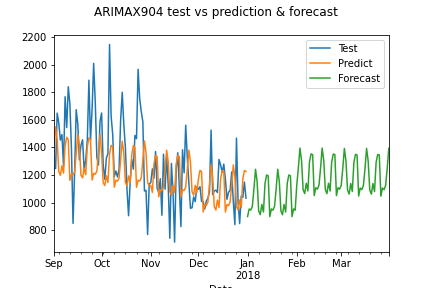

In [49]:
# arimax904
Image(filename='arimax904_test_pred.png') 

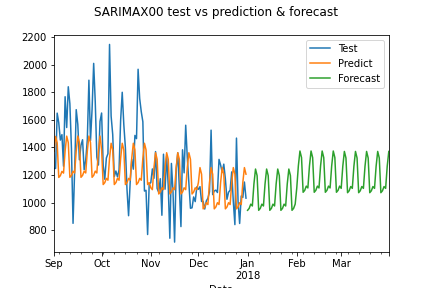

In [50]:
# sarimax000101
Image(filename='sarimax00_test_pred.png') 

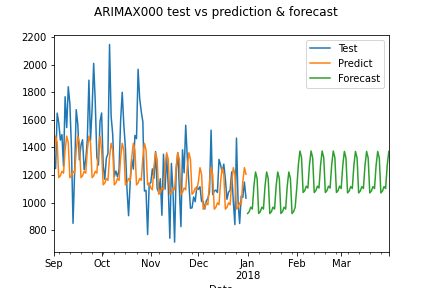

In [51]:
# arimax000
Image(filename='arimax000_test_pred.png') 

It looks like the day of week and month features helped a lot. All these three plots look very similar, except that arimax904 seems to suggest a slightly higher spike on every other week.
If there were more data, it would have taken longer to run SARIMAX, so I'd personally recommend running the ARIMAX model with more parameters to adjust with in the grid search.